In [5]:
# !pip install pandas-datareader

In [1]:
import pandas as pd
import numpy as np
from multiprocessing import Pool
from math import log
from datetime import datetime
from datetime import datetime, date, time, timezone
from datetime_truncate import truncate

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller as adf
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot
from pandas_datareader import data
from scipy import stats

### Data preperation

In [2]:
######## download data #########

df = pd.read_csv('/Users/k.dortsev/Desktop/btcusdt_5m.csv')
df['open_time'] = pd.to_datetime(df['open_time'], unit = 'ms')
df = df.set_index('open_time')
# d

In [3]:
######## some unnecessary columns ###########

columns_to_drop = ['open', 'high', 'low', 'volume', 'close_time', 'quote_vol',
       'trades', 'buy_vol', 'buy_q_vol', 'ignore']

df = df.drop(columns_to_drop, axis = 1)
df = df.dropna()
df.head(1000)

,close
open_time,
2018-11-06 04:30:00,6456.33
2018-11-06 04:35:00,6460.46
2018-11-06 04:40:00,6456.21
2018-11-06 04:45:00,6455.19
2018-11-06 04:50:00,6452.34
...,...
2018-11-09 15:25:00,6423.00
2018-11-09 15:30:00,6427.96
2018-11-09 15:35:00,6432.06


### Returns and Log RV

In [4]:
######## returns calculation #########

df = df.applymap(lambda x: np.log(x)) - df.applymap(lambda x: np.log(x)).shift(1)
df = df.rename(columns = {'close': 'returns'})
returns = df.dropna()
returns['sum_of_squares'] = returns.returns**2

######## RV calculation #############

returns['Log_realized_volatility'] = np.log(np.sqrt(returns['sum_of_squares'] + (returns['sum_of_squares']).shift(1)))
returns = returns.dropna()
returns

,returns,sum_of_squares,Log_realized_volatility
open_time,,,
2018-11-06 04:40:00,-0.000658,4.330487e-07,-6.993754
2018-11-06 04:45:00,-0.000158,2.496397e-08,-7.298184
2018-11-06 04:50:00,-0.000442,1.950129e-07,-7.664872
2018-11-06 04:55:00,0.000908,8.240745e-07,-6.898302
2018-11-06 05:00:00,0.000683,4.659697e-07,-6.780417
...,...,...,...
2022-11-03 12:05:00,0.000626,3.913309e-07,-6.717522
2022-11-03 12:10:00,-0.001140,1.299150e-06,-6.645249
2022-11-03 12:15:00,-0.000982,9.644332e-07,-6.499281


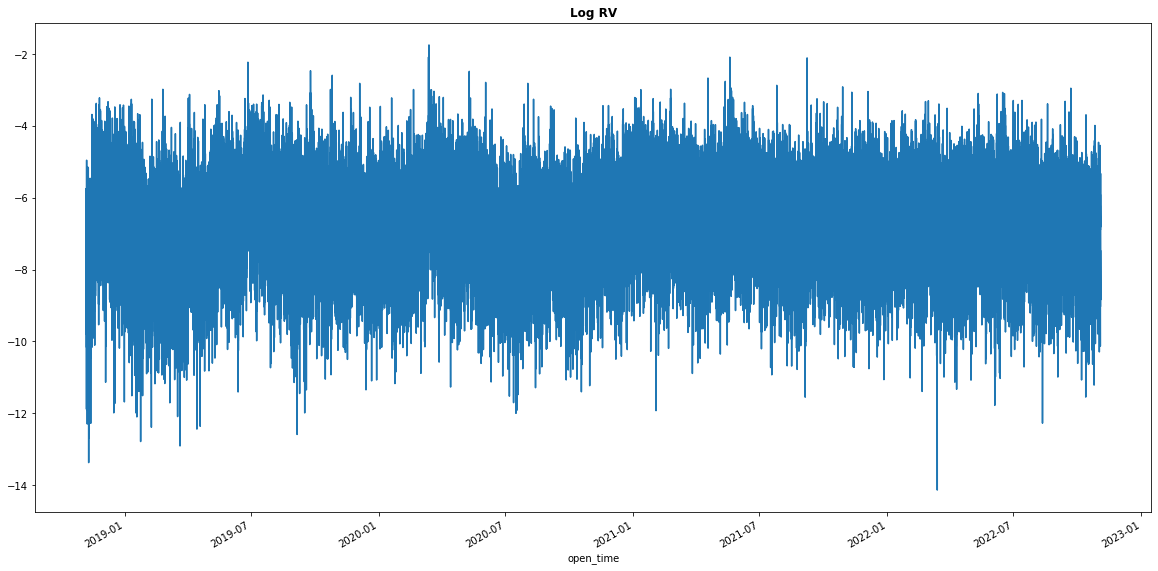

In [5]:
########### Log RV chart ############

returns['Log_realized_volatility'].plot(figsize=(20, 10))
plt.title("Log RV", weight="bold")

plt.show()

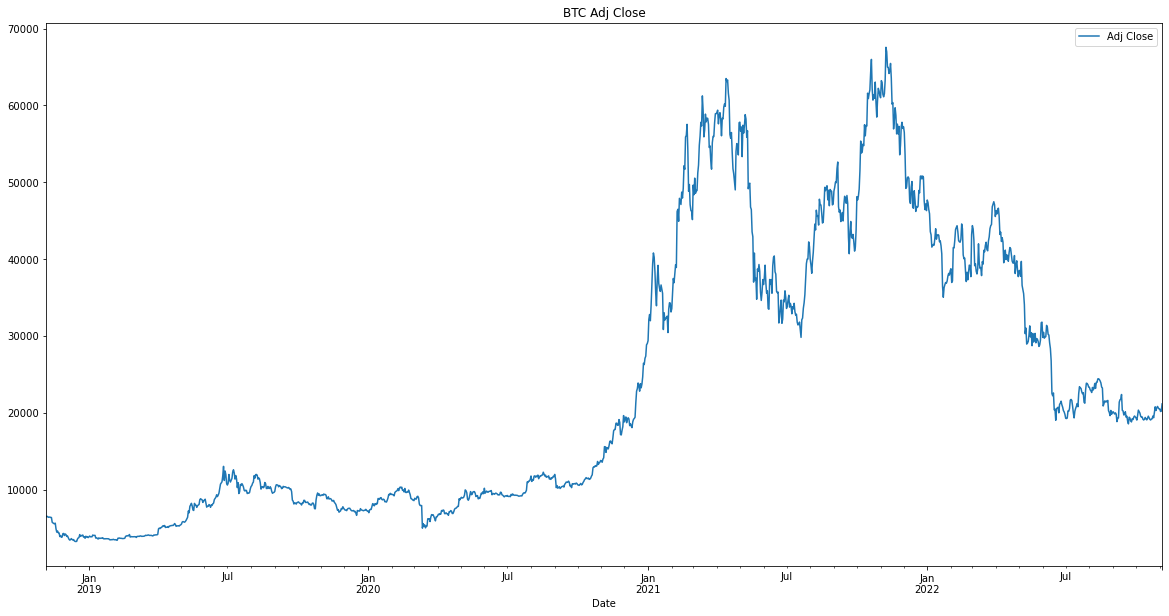

In [8]:
# Download VIX & SPY volume data from yahoo finance
start = str(df.index[0].date())
end = str(df.index[-1].date())

BTC_daily = data.DataReader("BTC-USD", start=start, end=end, data_source="yahoo")[["Adj Close"]]

BTC_daily.plot(title = "BTC Adj Close", figsize=(20, 10));plt.show()

In [9]:
# Compute number of periods/day
df["D"] = df.index.date
n_periods = df.pivot_table(index = ["D"], aggfunc = 'size').values

stats.describe(n_periods)

DescribeResult(nobs=1459, minmax=(150, 408), mean=287.8684030157642, variance=86.5917238539278, skewness=-2.893216864351894, kurtosis=101.53662667441972)

In [10]:
df.loc[df["D"] != df["D"].shift(), "Per"]  = n_periods
df.fillna(method = 'ffill', inplace = True)

df["Ret"] = np.where(df["D"] == df["D"].shift(),
                    ( (df["Close"]-df["Close"].shift()) * 1/df["Per"] ) **2, np.nan)

ValueError: shape mismatch: value array of shape (1459,) could not be broadcast to indexing result of shape (1469,)